# Chapter 07 - Unsupervised Learning

In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

In [2]:
SP500_DATA_CSV = '../data/sp500_data.csv.gz'
SP500_SECTORS_CSV = '../data/sp500_sectors.csv'
LOAN_DATA_CSV = '../data/loan_data.csv.gz'
HOUSE_TASKS_CSV = '../data/housetasks.csv'

## Principal Component Analysis

The idea in PCA is to combine multiple numeric predictor variables into a smaller set of variables, which are weighted linear combinations of the original set. The smaller set of variables, the principal components, “explains” most of the variability of the full set of variables, reducing the dimension of the data. The weights used to form the principal components reveal the relative contributions of the original variables to the new principal components.

### A Simple Example

In [3]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
oil_px.head()

,XOM,CVX
1993-01-29,-0.016991,0.072921
1993-02-01,0.016991,0.102089
1993-02-02,0.084954,0.029168
1993-02-03,0.067964,0.058337
1993-02-04,0.034378,0.044272


In [4]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)

loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
loadings

,XOM,CVX
0,-0.664711,-0.747101
1,0.747101,-0.664711


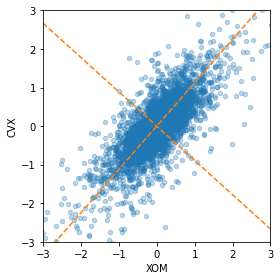

In [5]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

### Interpreting Principal Components

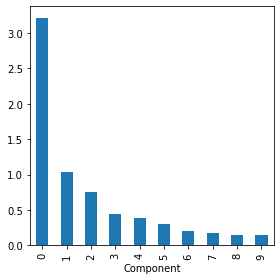

In [6]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()


In [7]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
loadings

,AAPL,AXP,COP,COST,CSCO,CVX,HD,INTC,JPM,MSFT,SLB,TGT,USB,WFC,WMT,XOM
0,-0.300825,-0.246332,-0.261529,-0.273634,-0.064059,-0.444490,-0.207983,-0.076956,-0.196397,-0.105012,-0.481786,-0.148833,-0.116421,-0.145684,-0.122304,-0.317952
1,-0.505116,-0.139426,0.174212,-0.416307,-0.031939,0.289373,-0.278002,-0.033898,-0.040723,-0.053954,0.472494,-0.228123,-0.054796,-0.047427,-0.222889,0.154192
2,-0.786730,0.135458,-0.002367,0.465862,-0.007524,0.082374,0.166320,-0.003518,0.062261,0.016248,-0.194822,0.160833,0.048976,0.041932,0.175806,0.090167
3,-0.120586,0.061814,-0.206026,0.092596,0.003904,-0.577665,0.162814,-0.001605,0.057687,-0.012558,0.680914,0.109895,0.016752,0.018614,0.058439,-0.295204
4,0.111576,-0.596666,-0.005813,0.555529,-0.039860,0.109016,-0.185488,-0.072047,-0.385160,-0.077135,0.181332,-0.055557,-0.155440,-0.216425,0.091541,0.013277


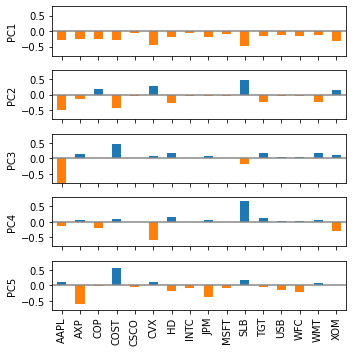

In [8]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()


### Correspondence Analysis

PCA cannot be used for categorical data; however, a somewhat related technique is correspondence analysis. The goal is to recognize associations between categories, or between categorical features.

The input can be seen as a table, with rows representing one variable and columns another, and the cells representing record counts. The output (after some matrix algebra) is a biplot—a scatterplot with axes scaled (and with percentages indicating how much variance is explained by that dimension). The meaning of the units on the axes is not intuitively connected to the original data, and the main value of the scatterplot is to illustrate graphically variables that are associated with one another (by proximity on the plot).

See for example, Figure 7-4, in which household tasks are arrayed according to whether they are done jointly or solo (vertical axis), and whether wife or husband has primary responsibility (horizontal axis). Correspondence analysis is many decades old, as is the spirit of this example, judging by the assignment of tasks.

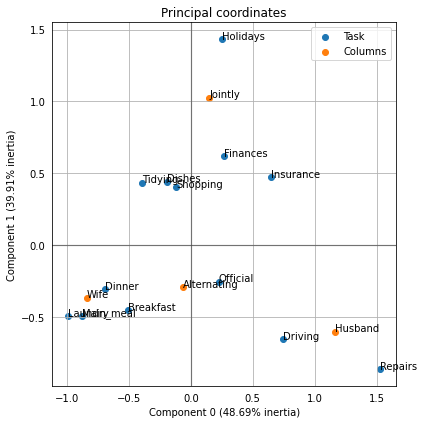

In [9]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(6, 6))
plt.tight_layout()
plt.show()

## Hierarchical Clustering

(17, 4)


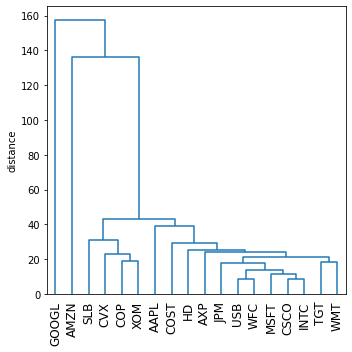

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


In [10]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

### The Dendrogram

fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

## Model-Based Clustering

In the past 20 years, significant effort has been devoted to developing model-based clustering methods. The
techniques are grounded in statistical theory and provide more rigorous ways to determine the nature and number of clusters. They could be used, for example, in cases where there might be one group of records that are similar to one another but not necessarily close to one another (e.g., tech stocks with high variance of returns), and another group of records that are similar and also close (e.g., utility stocks with low variance).

## Scaling and Categorical Variables

In the case of categorical data, you must convert it to numeric data, either by ranking (for an ordered factor) or by encoding as a set of binary (dummy) variables. If the data consists of mixed continuous and binary variables, you will usually want to scale the variables so that the ranges are similar. One popular method is to use **Gower's distance**.

## Summary

For dimension reduction of numeric data, the main tools are either principal components analysis or K-means clustering. Both require attention to proper scaling of the data to ensure meaningful data reduction.

For clustering with highly structured data in which the clusters are well separated, all methods will likely produce a similar result. Each method offers its own advantage. K-means scales to very large data and is easily understood. Hierarchical clustering can be applied to mixed data types—numeric and categorical—and lends itself to an intuitive display (the dendrogram). Model-based clustering is founded on statistical theory and provides a more rigorous approach, as opposed to the heuristic methods. For very large data, however, K-means is the main method used.

With noisy data, such as the loan and stock data (and much of the data that a data scientist will face), the choice is more stark. K-means, hierarchical clustering, and especially model-based clustering all produce very different solutions. How should a data scientist proceed? Unfortunately, there is no simple rule of thumb to guide the choice. **Ultimately, the method used will depend on the data size and the goal of the
application**.